<a href="https://colab.research.google.com/github/DougChul/Ferroelectric-ThinFilm-Poling/blob/main/KAI_Prisach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cp= 1.71068134e-09  F
0.0159051602473855


<ipython-input-8-6c89c534664b>:74: RuntimeWarning: overflow encountered in exp
  tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
<ipython-input-8-6c89c534664b>:81: RuntimeWarning: overflow encountered in exp
  tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))


Max value fo p_sum
1.0061091244545408
Max value of P
0.23787128849363418


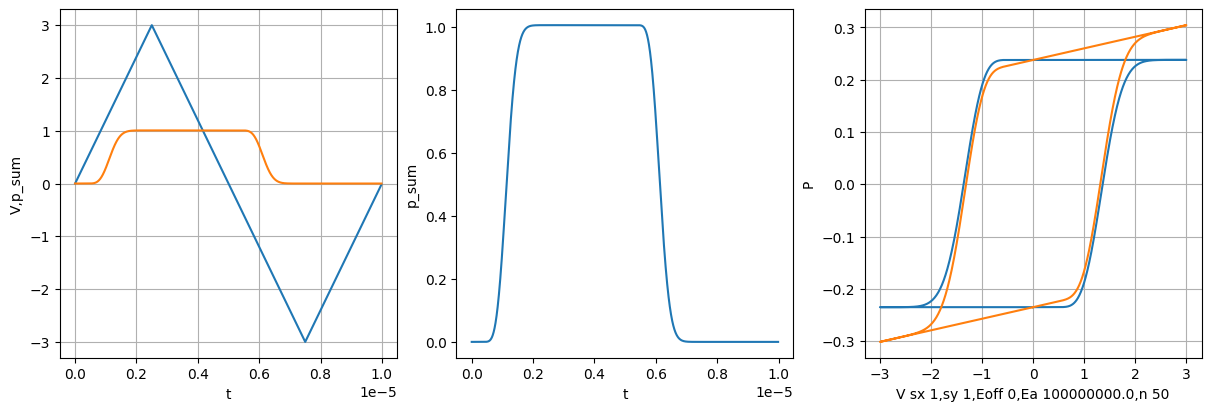

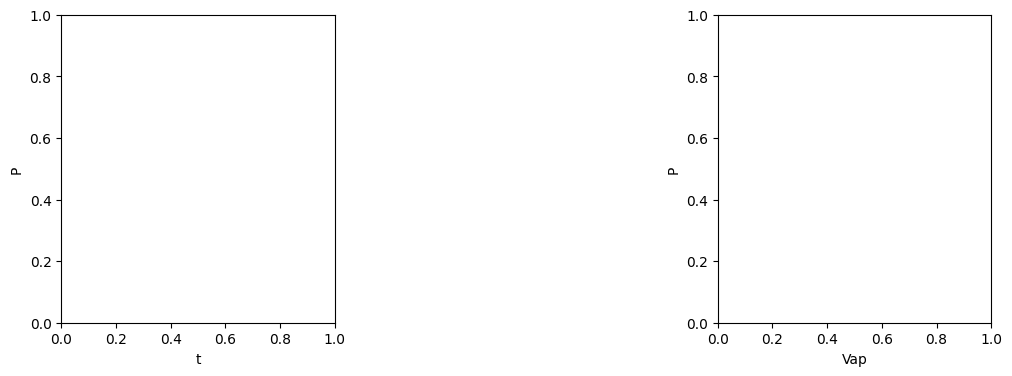

In [ ]:
# @title
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gamma
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os
from scipy.stats import cauchy  # 코시 분포
from scipy.integrate import simpson # 적분

n_sample=50

scale_x = 1
scale_y = 1

E_x_range=scale_x*637
E_y_range=scale_y*637

side_num=n_sample*0.04  # left right sample 개수
mid_num=(n_sample-2*side_num) # 중간 sample 개수 고밀도.
den=20

# 낮은 확률 부분은 CDF<0.01 부분은 2% sample CDF>0.01 부분은 98% sample 배정
x_median=np.linspace(-E_x_range/den,E_x_range/den,int(mid_num)+2)[1:-1]
x_left=np.linspace(-E_x_range,-E_x_range/den, int(side_num))
x_right=np.linspace(E_x_range/den, E_x_range, int(side_num))

x=np.concatenate([x_left,x_median,x_right]) # 합친 x의 sample 간격

y_median=np.linspace(-E_y_range/den,E_y_range/den,int(mid_num)+2)[1:-1]
y_left=np.linspace(-E_y_range, -E_y_range/den, int(side_num))
y_right=np.linspace(E_y_range/den, E_y_range, int(side_num))

y=np.concatenate([y_left, y_median, y_right]) # 합친 x의 sample 간격

x_avg=np.zeros(n_sample-1)
y_avg=np.zeros(n_sample-1)

for i in range(0,n_sample-1):  # 중앙값으로 체크.
  x_avg[i]=(x[i]+x[i+1])/2
  y_avg[i]=(y[i]+y[i+1])/2

X, Y = np.meshgrid(x_avg, y_avg)

pdf_array = cauchy.pdf(X, loc=0, scale=scale_x) * cauchy.pdf(Y, loc=0, scale=scale_y)

# 행 기준(가로 방향) 적분
#row_integral = simpson(pdf_array, x_avg, axis=1)
#print(row_integral)
# 열 기준(세로 방향) 적분
#col_integral = simpson(row_integral, y_avg)
#print(col_integral)

####### KAI

Thickness = 10e-9 # [m]
Area = (278*278)*1e-12 # [m2]
Ps=0.235 # [c/m2]

# Set parameter for Merz' law
alpha = 2  # second dimension
tau0 = 500e-9 #[s]
Eoff0 = 0 #2e+8 #[V/m]
Ea0 = 1e+8 #[V/m] 1.5e+8

# tau
def tauP(E):  # 위 아래 식 동일함.
    if E>Eoff:   #|E|가 충분히 작으면 tau 최댓값 설정. or 계산.
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:   # E<0 이면 어차피 수식에서 쓰이지 않음.
        tau = tau0*np.exp(100)
    return tau

def tauM(E):
    if E<Eoff:
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:
        tau = tau0*np.exp(100)
    return tau

# beta
B = 2

# Parallel linear element
Cp = 8.854e-12*25*Area/Thickness #[F]
#Rp = 5e9 #[ohm]
Rs = 50 #[ohm]
print('Cp=',Cp,' F')

print(8.854e-12*25*0.718552529811859/10e-9)


# In[2]: Parameter of apllied Signal

f = 100000 #[Hz]
Vamp = 3 #[V]
# #sin wave
# def Vext(t):
#     return Vamp*np.sin(2*np.pi*f*t)
#triangular wave
def Vext(t):
    return Vamp*4*f*abs(divmod(t-1/4/f,1/f)[1]-1/2/f)-Vamp


# In[3]: Parameter of loop

dt = 0.05e-7
ilist=list(range(1,2000)) # 1999 길이의 배열. time에 대한거임.
tP = np.zeros(len(ilist)) # Tinc+
tM = np.zeros(len(ilist)) # Tinc-
T = np.zeros(len(ilist)) # Time
Vap = np.ones(len(ilist))*1e-21   # 배열 1로 채워서 선언.
V_Cp = np.zeros(len(ilist))
Q_Cp = np.zeros(len(ilist))
p = np.zeros(len(ilist))
p_sum = np.zeros(len(ilist))

# Parameter of N

dx = np.diff(x)  # x 방향의 간격 개수 하나 줄어들음.
dy = np.diff(y)  # y 방향의 간격

mesh_area = dx[:, None] * dy[None, :] # 각 mesh 면적

##### 반복문
for a in range(0,n_sample-1):
  for b in range(0,n_sample-1):
    Eoff=Eoff0+X[a,b] # E_off 값 보정, 범위 안의 index 값임.
    Ea=Ea0+Y[a,b] # Ea 값 보정.
    for i in ilist[1:len(ilist)-1]: # i=2 부터 i=199999 배열 index 0 부터 시작이므로 last index = len(list) - 1 이다.
      T[i] = T[i-1]+dt # 기본 time은 accumulation of fixed dt
      tP[i] = tP[i-1]+dt # 딱히 0이어도 문제 없을거 같은데, if 1dt면 미소값이므로 0으로 근사 가능 될거고,
      tM[i] = tM[i-1]+dt # 일단 둘 다 dt 넣어놓고 계산 후에 아래에서 다시 처리,
      Vap[i] = Vext(T[i]) #가해진 삼각파 or sin wave Voltage directly apply to ferro.
      p[i] = ((1-B*(tM[i])**(B-1)/tauM(Vap[i]/Thickness)**B*dt)*p[i-1]+B*(tP[i])**(B-1)/tauP(Vap[i]/Thickness)**B*dt*(1-p[i-1]))
      tP[i] = np.where((Vap[i]/Thickness-Eoff)<Ea*0.01,0,tP[i-1]+dt) # E field 음수면 tP=0
      tM[i] = np.where((Vap[i]/Thickness-Eoff)>Ea*0.01,0,tM[i-1]+dt) # E field 양수면 tM=0

    p_sum=p_sum+p*pdf_array[a,b]*mesh_area[a,b]

Vap = np.array(Vap)
Q_Cp = Cp*Vap

P = 2*Ps*(np.array(p_sum)-0.5) # 2Ps는 미분에 포함 안된 계수.
print('Max value fo p_sum')
print(np.max(p_sum)) # 그럼 더하는건 문제가 아님.
print('Max value of P')
print(np.max(P))

#V_Cp = Q_Cp/Cp
#I_Rp = Vap/Rp
#Q_Rp = np.cumsum(I_Rp)*dt
#V_Rs = Vap-V_Cp
#I_Rs = V_Rs/Rs
#I_Cp = np.diff(P,prepend=0)
PQ=P+(Q_Cp)/Area

plt.figure(figsize=(12,4),constrained_layout=True)
plt.subplot(1,3,1);plt.xlabel('t');plt.ylabel('V,p_sum')
plt.plot(T,Vap)
plt.plot(T,p_sum)
plt.grid()
plt.subplot(1,3,2); plt.xlabel('t'); plt.ylabel('p_sum')
plt.plot(T,p_sum)

plt.subplot(1,3,3);plt.xlabel(f"V sx {scale_x},sy {scale_y},Eoff {Eoff0},Ea {Ea0},n {n_sample}");plt.ylabel('P')
plt.grid()
# plt.plot(Vap,Q_Cp/Area)
# plt.plot(Vap,Q_Rp/Area)
plt.plot(Vap,P)
#plt.plot(Vap,P+(Q_Cp+Q_Rp)/Area)
plt.plot(Vap,P+(Q_Cp)/Area)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.xlabel('t'); plt.ylabel('P')

plt.subplot(1,3,3); plt.xlabel('Vap'); plt.ylabel('P')


#[Export .xlsx] #################

df_V = pd.DataFrame(Vap); df_PQ=pd.DataFrame(PQ); df_pdf=pd.DataFrame(pdf_array);

df_V['P']=df_PQ

with pd.ExcelWriter(f'output_sx_{scale_x},sy_{scale_y}_Eoff_{Eoff0}_Ea_{Ea0}_f_{f}_n_{n_sample}.xlsx') as writer:
    df_V.to_excel(writer, sheet_name='P', index=False)
    df_pdf.to_excel(writer, sheet_name='pdf', index=False)




Cp= 1.71068134e-09  F
0.0159051602473855


<ipython-input-25-01d5b619b2e8>:74: RuntimeWarning: overflow encountered in exp
  tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
<ipython-input-25-01d5b619b2e8>:81: RuntimeWarning: overflow encountered in exp
  tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))


Max value fo p_sum
0.9353914438958696
Max value of P
0.2351113797037696


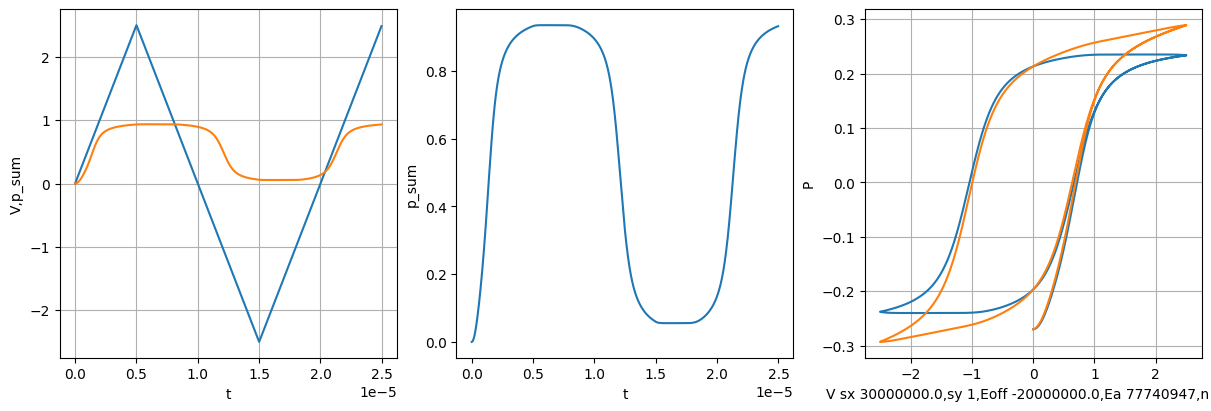

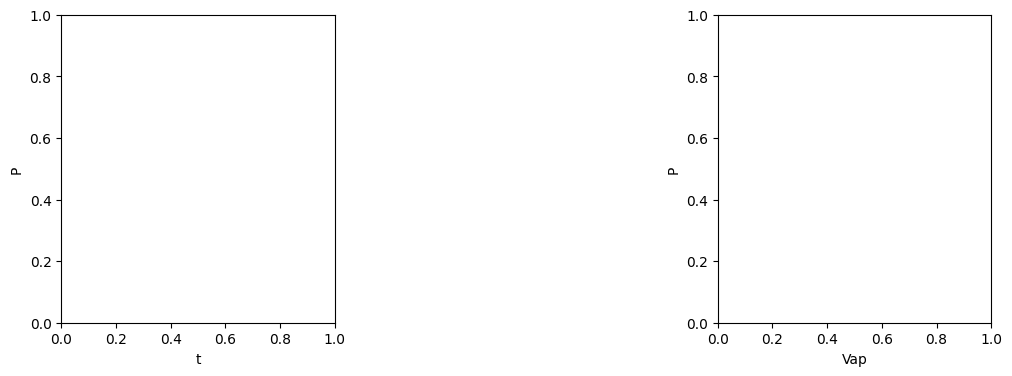

In [ ]:
# @title
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gamma
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os
from scipy.stats import cauchy  # 코시 분포
from scipy.integrate import simpson # 적분

n_sample=100

scale_x = 3e+7
scale_y = 1

E_x_range=scale_x*637
E_y_range=scale_y*637

side_num=n_sample*0.04  # left right sample 개수
mid_num=(n_sample-2*side_num) # 중간 sample 개수 고밀도.
den=20

# 낮은 확률 부분은 CDF<0.01 부분은 2% sample CDF>0.01 부분은 98% sample 배정
x_median=np.linspace(-E_x_range/den,E_x_range/den,int(mid_num)+2)[1:-1]
x_left=np.linspace(-E_x_range,-E_x_range/den, int(side_num))
x_right=np.linspace(E_x_range/den, E_x_range, int(side_num))

x=np.concatenate([x_left,x_median,x_right]) # 합친 x의 sample 간격

y_median=np.linspace(-E_y_range/den,E_y_range/den,int(mid_num)+2)[1:-1]
y_left=np.linspace(-E_y_range, -E_y_range/den, int(side_num))
y_right=np.linspace(E_y_range/den, E_y_range, int(side_num))

y=np.concatenate([y_left, y_median, y_right]) # 합친 x의 sample 간격

x_avg=np.zeros(n_sample-1)
y_avg=np.zeros(n_sample-1)

for i in range(0,n_sample-1):  # 중앙값으로 체크.
  x_avg[i]=(x[i]+x[i+1])/2
  y_avg[i]=(y[i]+y[i+1])/2

X, Y = np.meshgrid(x_avg, y_avg)

pdf_array = cauchy.pdf(X, loc=0, scale=scale_x) * cauchy.pdf(Y, loc=0, scale=scale_y)

# 행 기준(가로 방향) 적분
#row_integral = simpson(pdf_array, x_avg, axis=1)
#print(row_integral)
# 열 기준(세로 방향) 적분
#col_integral = simpson(row_integral, y_avg)
#print(col_integral)

####### KAI

Thickness = 10e-9 # [m]
Area = (278*278)*1e-12 # [m2]
Ps=0.27 # [c/m2]

# Set parameter for Merz' law
alpha = 2  # second dimension
tau0 = 500e-9 #[s]
Eoff0 = -2e+7 #1.5e+8 #2e+8 #[V/m]
Ea0 = 77740947 #1.0e+8 #[V/m] 1.5e+8

# tau
def tauP(E):  # 위 아래 식 동일함.
    if E>Eoff:   #|E|가 충분히 작으면 tau 최댓값 설정. or 계산.
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:   # E<0 이면 어차피 수식에서 쓰이지 않음.
        tau = tau0*np.exp(100)
    return tau

def tauM(E):
    if E<Eoff:
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:
        tau = tau0*np.exp(100)
    return tau

# beta
B = 2

# Parallel linear element
Cp = 8.854e-12*25*Area/Thickness #[F]
#Rp = 5e9 #[ohm]
Rs = 50 #[ohm]
print('Cp=',Cp,' F')

print(8.854e-12*25*0.718552529811859/10e-9)


# In[2]: Parameter of apllied Signal

f = 50000 #[Hz]
Vamp = 2.5 #[V]
# #sin wave
# def Vext(t):
#     return Vamp*np.sin(2*np.pi*f*t)
#triangular wave
def Vext(t):
    return Vamp*4*f*abs(divmod(t-1/4/f,1/f)[1]-1/2/f)-Vamp


# In[3]: Parameter of loop

dt = 0.1e-7
ilist=list(range(1,2500)) # 1999 길이의 배열. time에 대한거임.
tP = np.zeros(len(ilist)) # Tinc+
tM = np.zeros(len(ilist)) # Tinc-
T = np.zeros(len(ilist)) # Time
Vap = np.ones(len(ilist))*1e-21   # 배열 1로 채워서 선언.
V_Cp = np.zeros(len(ilist))
Q_Cp = np.zeros(len(ilist))
p = np.zeros(len(ilist))
p_sum = np.zeros(len(ilist))

# Parameter of N

dx = np.diff(x)  # x 방향의 간격 개수 하나 줄어들음.
dy = np.diff(y)  # y 방향의 간격

mesh_area = dx[:, None] * dy[None, :] # 각 mesh 면적

##### 반복문
for a in range(0,n_sample-1):
  for b in range(0,n_sample-1):
    Eoff=Eoff0+X[a,b] # E_off 값 보정, 범위 안의 index 값임.
    Ea=Ea0+Y[a,b] # Ea 값 보정.
    for i in ilist[1:len(ilist)-1]: # i=2 부터 i=199999 배열 index 0 부터 시작이므로 last index = len(list) - 1 이다.
      T[i] = T[i-1]+dt # 기본 time은 accumulation of fixed dt
      tP[i] = tP[i-1]+dt # 딱히 0이어도 문제 없을거 같은데, if 1dt면 미소값이므로 0으로 근사 가능 될거고,
      tM[i] = tM[i-1]+dt # 일단 둘 다 dt 넣어놓고 계산 후에 아래에서 다시 처리,
      Vap[i] = Vext(T[i]) #가해진 삼각파 or sin wave Voltage directly apply to ferro.
      p[i] = ((1-B*(tM[i])**(B-1)/tauM(Vap[i]/Thickness)**B*dt)*p[i-1]+B*(tP[i])**(B-1)/tauP(Vap[i]/Thickness)**B*dt*(1-p[i-1]))
      tP[i] = np.where((Vap[i]/Thickness-Eoff)<Ea*0.01,0,tP[i-1]+dt) # E field 음수면 tP=0
      tM[i] = np.where((Vap[i]/Thickness-Eoff)>Ea*0.01,0,tM[i-1]+dt) # E field 양수면 tM=0

    p_sum=p_sum+p*pdf_array[a,b]*mesh_area[a,b]

Vap = np.array(Vap)
Q_Cp = Cp*Vap

P = 2*Ps*(np.array(p_sum)-0.5) # 2Ps는 미분에 포함 안된 계수.
print('Max value fo p_sum')
print(np.max(p_sum)) # 그럼 더하는건 문제가 아님.
print('Max value of P')
print(np.max(P))

#V_Cp = Q_Cp/Cp
#I_Rp = Vap/Rp
#Q_Rp = np.cumsum(I_Rp)*dt
#V_Rs = Vap-V_Cp
#I_Rs = V_Rs/Rs
#I_Cp = np.diff(P,prepend=0)
PQ=P+(Q_Cp)/Area

plt.figure(figsize=(12,4),constrained_layout=True)
plt.subplot(1,3,1);plt.xlabel('t');plt.ylabel('V,p_sum')
plt.plot(T,Vap)
plt.plot(T,p_sum)
plt.grid()
plt.subplot(1,3,2); plt.xlabel('t'); plt.ylabel('p_sum')
plt.plot(T,p_sum)

plt.subplot(1,3,3);plt.xlabel(f"V sx {scale_x},sy {scale_y},Eoff {Eoff0},Ea {Ea0},n {n_sample}");plt.ylabel('P')
plt.grid()
# plt.plot(Vap,Q_Cp/Area)
# plt.plot(Vap,Q_Rp/Area)
plt.plot(Vap,P)
#plt.plot(Vap,P+(Q_Cp+Q_Rp)/Area)
plt.plot(Vap,P+(Q_Cp)/Area)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.xlabel('t'); plt.ylabel('P')

plt.subplot(1,3,3); plt.xlabel('Vap'); plt.ylabel('P')


#[Export .xlsx] #################

df_V = pd.DataFrame(Vap); df_PQ=pd.DataFrame(PQ); df_pdf=pd.DataFrame(pdf_array);

df_V['P']=df_PQ

with pd.ExcelWriter(f'output_sx_{scale_x},sy_{scale_y}_Eoff_{Eoff0}_Ea_{Ea0}_f_{f}_n_{n_sample}.xlsx') as writer:
    df_V.to_excel(writer, sheet_name='P', index=False)
    df_pdf.to_excel(writer, sheet_name='pdf', index=False)




In [ ]:
# @title
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gamma
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os
from scipy.stats import cauchy  # 코시 분포
from scipy.integrate import simps # 적분

E_x_median=0
E_y_median=0
n_sample=100

scale_x = 0.1
scale_y = 0.1

E_x_range=scale_x*637
E_y_range=scale_y*637

# 낮은 확률 부분은 CDF<0.01 부분은 2% sample CDF>0.01 부분은 98% sample 배정
x_median=np.linspace(E_x_median-E_x_range/10,E_x_median+E_x_range/10,int(n_sample*0.96))
x_left=np.linspace(E_x_median-E_x_range, E_x_median-E_x_range/10, int(n_sample*0.02))
x_right=np.linspace(E_x_median+E_x_range/10, E_x_median+E_x_range, int(n_sample*0.02))

x=np.concatenate([x_left,x_median,x_right]) # 합친 x의 sample 간격

y_median=np.linspace(E_y_median-E_y_range/10,E_y_median+E_y_range/10,int(n_sample*0.96))
y_left=np.linspace(E_y_median-E_y_range, E_y_median-E_y_range/10, int(n_sample*0.02))
y_right=np.linspace(E_y_median+E_y_range/10, E_y_median+E_y_range, int(n_sample*0.02))

y=np.concatenate([y_left, y_median, y_right]) # 합친 y의 sample 간격

X, Y = np.meshgrid(x, y)

pdf_array = cauchy.pdf(X, loc=E_x_median, scale=scale_x) * cauchy.pdf(Y, loc=E_y_median, scale=scale_y)

print(X[1,0])
print(pdf_array[49,49])

-63.7
4.821704315416782


In [ ]:
# @title
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gamma
import scipy.interpolate as ip
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os
from scipy.stats import cauchy  # 코시 분포
from scipy.integrate import simpson # 적분
import cupy as cp  # 추가

n_sample=100

scale_x = 1
scale_y = 1

E_x_range=scale_x*637
E_y_range=scale_y*637

side_num=n_sample*0.02  # left right sample 개수
mid_num=(n_sample-2*side_num) # 중간 sample 개수 고밀도.
cx=0#E_x_range*9/10/(side_num-1) # 그냥 넣으면 배열이 겹침. 보정값.
cy=0#E_y_range*9/10/(side_num-1)

# 낮은 확률 부분은 CDF<0.01 부분은 2% sample CDF>0.01 부분은 98% sample 배정
x_median=cp.linspace(-E_x_range/10+cx,E_x_range/10-cx,int(mid_num))
x_left=cp.linspace(-E_x_range,-E_x_range/10, int(side_num))
x_right=cp.linspace(E_x_range/10, E_x_range, int(side_num))

x=cp.concatenate([x_left,x_median,x_right]) # 합친 x의 sample 간격

#print(x)
y_median=cp.linspace(-E_y_range/10+cy,E_y_range/10-cy,int(mid_num))
y_left=cp.linspace(-E_y_range, -E_y_range/10, int(side_num))
y_right=cp.linspace(E_y_range/10, E_y_range, int(side_num))

y=cp.concatenate([y_left, y_median, y_right]) # 합친 x의 sample 간격

x_avg=cp.zeros(n_sample-1)
y_avg=cp.zeros(n_sample-1)

for i in range(0,n_sample-1):  # 중앙값으로 체크.
  x_avg[i]=(x[i]+x[i+1])/2
  y_avg[i]=(y[i]+y[i+1])/2

X, Y = cp.meshgrid(x_avg, y_avg)

pdf_array = cp.array(cauchy.pdf(cp.asnumpy(X), loc=0, scale=scale_x) *
                    cauchy.pdf(cp.asnumpy(Y), loc=0, scale=scale_y))

# 행 기준(가로 방향) 적분
#row_integral = simpson(pdf_array, x_avg, axis=1)
#print(row_integral)
# 열 기준(세로 방향) 적분
#col_integral = simpson(row_integral, y_avg)
#print(col_integral)

####### KAI

Thickness = 10e-9 # [m]
Area = 10000e-12 # [m2]
Ps=0.1 # [c/m2]

# Set parameter for Merz' law
alpha = 2  # second dimension
tau0 = 500e-9 #[s]
Eoff0 = 0 #1.5e+8 #2e+8 #[V/m]
Ea0 = 1.0e+8 #[V/m] 1.5e+8

# tau
def tauP(E):  # 위 아래 식 동일함.
    if E>Eoff:   #|E|가 충분히 작으면 tau 최댓값 설정. or 계산.
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:   # E<0 이면 어차피 수식에서 쓰이지 않음.
        tau = tau0*np.exp(100)
    return tau

def tauM(E):
    if E<Eoff:
        tau=np.where(((Ea)/abs(E-Eoff))**alpha >100,tau0*np.exp(100),tau0*np.exp(((Ea)/abs(E-Eoff))**alpha))
    else:
        tau = tau0*np.exp(100)
    return tau

# beta
B = 2

# Parallel linear element
Cp = 8.854e-12*25*Area/Thickness #[F]
Rp = 5e9 #[ohm]
Rs = 50 #[ohm]
print('Cp=',Cp,' F')


# In[2]: Parameter of apllied Signal

f = 100000 #[Hz]
Vamp = 3.5 #[V]
# #sin wave
# def Vext(t):
#     return Vamp*np.sin(2*np.pi*f*t)
#triangular wave
def Vext(t):
    return Vamp*4*f*abs(divmod(t-1/4/f,1/f)[1]-1/2/f)-Vamp


# In[3]: Parameter of loop

dt = 0.25e-7
ilist=list(range(1,2000)) # 1999 길이의 배열. time에 대한거임.
tP = cp.zeros(len(ilist)) # Tinc+
tM = cp.zeros(len(ilist)) # Tinc-
T = cp.zeros(len(ilist)) # Time
Vap = cp.ones(len(ilist))*1e-21   # 배열 1로 채워서 선언.
V_Cp = cp.zeros(len(ilist))
Q_Cp = cp.zeros(len(ilist))
p = cp.zeros(len(ilist))
p_sum = cp.zeros(len(ilist))

# Parameter of N

dx = cp.diff(x)  # x 방향의 간격 개수 하나 줄어들음.
dy = cp.diff(y)  # y 방향의 간격

mesh_area = dx[:, None] * dy[None, :] # 각 mesh 면적

##### 반복문
for a in range(0,n_sample-1):
  for b in range(0,n_sample-1):
    Eoff=Eoff0+X[a,b] # E_off 값 보정, 범위 안의 index 값임.
    Ea=Ea0+Y[a,b] # Ea 값 보정.
    for i in ilist[1:len(ilist)-1]: # i=2 부터 i=199999 배열 index 0 부터 시작이므로 last index = len(list) - 1 이다.
      T[i] = T[i-1]+dt # 기본 time은 accumulation of fixed dt
      tP[i] = tP[i-1]+dt # 딱히 0이어도 문제 없을거 같은데, if 1dt면 미소값이므로 0으로 근사 가능 될거고,
      tM[i] = tM[i-1]+dt # 일단 둘 다 dt 넣어놓고 계산 후에 아래에서 다시 처리,
      Vap[i] = Vext(T[i]) #가해진 삼각파 or sin wave Voltage directly apply to ferro.
      p[i] = ((1-B*(tM[i])**(B-1)/tauM(Vap[i]/Thickness)**B*dt)*p[i-1]+B*(tP[i])**(B-1)/tauP(Vap[i]/Thickness)**B*dt*(1-p[i-1]))
      tP[i] = np.where((Vap[i]/Thickness-Eoff)<Ea*0.01,0,tP[i-1]+dt) # E field 음수면 tP=0
      tM[i] = np.where((Vap[i]/Thickness-Eoff)>Ea*0.01,0,tM[i-1]+dt) # E field 양수면 tM=0

    p_sum=p_sum+p*pdf_array[a,b]*mesh_area[a,b]

Vap = cp.array(Vap)
Q_Cp = Cp*Vap

P = 2*Ps*(cp.array(p_sum)-0.5) # 2Ps는 미분에 포함 안된 계수.
print('Max value fo p_sum')
print(np.max(p_sum)) # 그럼 더하는건 문제가 아님.
print('Max value of P')
print(np.max(P))

V_Cp = Q_Cp/Cp
I_Rp = Vap/Rp
Q_Rp = np.cumsum(I_Rp)*dt
V_Rs = Vap-V_Cp
I_Rs = V_Rs/Rs
I_Cp = np.diff(P,prepend=0)

plt.figure(figsize=(12,4),constrained_layout=True)
plt.subplot(1,3,1);plt.xlabel('t');plt.ylabel('V,p_sum')
plt.plot(cp.asnumpy(T), cp.asnumpy(Vap))
plt.plot(cp.asnumpy(T), cp.asnumpy(p_sum))
plt.grid()
plt.subplot(1,3,2); plt.xlabel('t'); plt.ylabel('p_sum')
plt.plot(cp.asnumpy(T), cp.asnumpy(p_sum))

plt.subplot(1,3,3);plt.xlabel(f"V sx {scale_x},sy {scale_y},Eoff {Eoff0},Ea {Ea0},n {n_sample}");plt.ylabel('P')
plt.grid()
# plt.plot(Vap,Q_Cp/Area)
plt.plot(cp.asnumpy(Vap), cp.asnumpy(Q_Rp)/Area)
plt.plot(cp.asnumpy(Vap), cp.asnumpy(P))
plt.plot(cp.asnumpy(Vap), cp.asnumpy(P+(Q_Cp+Q_Rp)/Area))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.xlabel('t'); plt.ylabel('P')

plt.subplot(1,3,3); plt.xlabel('Vap'); plt.ylabel('P')


#[Export .xlsx] #################

df_P = pd.DataFrame(cp.asnumpy(P)); df_X = pd.DataFrame(cp.asnumpy(X)); df_Y = pd.DataFrame(cp.asnumpy(Y)); df_Vap = pd.DataFrame(cp.asnumpy(Vap));

with pd.ExcelWriter(f'output_sx_{scale_x},sy_{scale_y}_Eoff_{Eoff0}_Ea_{Ea0}_f_{f}_n_{n_sample}.xlsx') as writer:
    df_P.to_excel(writer, sheet_name='P', index=True)
    df_X.to_excel(writer, sheet_name='X', index=True)
    df_Y.to_excel(writer, sheet_name='Y', index=True)
    df_Vap.to_excel(writer, sheet_name='Vap', index=True)




Cp= 2.2134999999999996e-10  F
